# Installing and Running Voila

To install Voila for dashboarding with Jupyter notebooks and set up an example notebook, follow these instructions:

1. Install Voila:

    - Open a terminal or command prompt.
    - Ensure you have an active Python environment (e.g., virtual environment).
    - Run the following command to install Voila using pip:
    - `pip install voila pandas jupyter` etc

2. Launch Voila:

    - Open a terminal or command prompt.
    - Navigate to the directory containing your Jupyter notebook.
    - Run the following command to launch Voila and serve your notebook as a dashboard:
    ` voila <notebook_name>.ipynb`
    -  Replace <notebook_name>.ipynb with the actual name of your Jupyter notebook file.

3. Access the dashboard:

    - Once Voila is running, it will display a local web server address (e.g., http://localhost:8866/).
    - Open a web browser and enter the provided address to access your Voila dashboard.
    - You can share this URL with others to allow them to view the dashboard.

# Getting Started

In [6]:
# Import libraries
from dotenv import load_dotenv
import os
from os import environ as env
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

In [7]:

# Load environment variables
load_dotenv()
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

In [8]:
# Connect to the Stack Overflow database
conn = psycopg2.connect(
    host=db_host,
    database=db_name,
    user=db_user,
    password=db_password
)

In [9]:


# Define HEART metrics for Stack Overflow
heart_metrics = {
    'Happiness': 'Measure of user satisfaction and happiness with the Questions & Answers product.',
    'Engagement': 'Measure of user interaction and activity on the platform.',
    'Adoption': 'Measure of user acquisition and growth of Stack Overflow user base.',
    'Retention': 'Measure of user retention and continued usage of the platform over time.',
    'Task Success': 'Measure of user ability to accomplish their goals and tasks effectively on Stack Overflow.'
}


### Create a SQLalchemy Engine

Use the following code to connect to the DB and transfer the results to `pandas` more easily for exploration.

In [10]:
from sqlalchemy import create_engine


# With the env variables loaded we can insert them into the engine connection string.
engine = create_engine(f"postgresql+psycopg2://{env['DB_USER']}:{env['DB_PASSWORD']}@{env['DB_HOST']}/{env['DB_NAME']}")
connection = engine.connect()

Test the connection engine

In [11]:
query = "SELECT * FROM users LIMIT 5"
df = pd.read_sql(query, connection)

# Example Metric Analysis

Let's take a look at one of the HEART metrics, Adoption. 

First of all, as an example, we are going to load in the data from the Users table and identify how many unique users signed up per month. I will give the following code using Pandas, we will then go onto using SQL equivalents that you may find more helpful, and indeed faster, in order to complete your project.

In [12]:
query = "SELECT * FROM users ORDER BY creation_date LIMIT 50000"
df = pd.read_sql(query, connection)

In [13]:
df['creation_date'] = pd.to_datetime(df['creation_date'])

df['c_date'] = df['creation_date'].dt.date

df['c_date']

0        2008-07-31
1        2008-07-31
2        2008-07-31
3        2008-07-31
4        2008-07-31
            ...    
49995    2009-07-15
49996    2009-07-15
49997    2009-07-15
49998    2009-07-15
49999    2009-07-15
Name: c_date, Length: 50000, dtype: object

In [14]:
pd.DatetimeIndex(df['c_date']).to_period("M")

df.head()

,id,account_id,reputation,views,down_votes,up_votes,display_name,location,profile_image_url,website_url,about_me,creation_date,last_access_date,c_date
0,-1,-1,1,127553,1486341,591286,Community,on the server farm,None,https://meta.stackexchange.com,"<p>Hi, I'm not really a person.</p>\n<p>I'm a ...",2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,2008-07-31
1,1,1,63031,592599,1312,3407,Jeff Atwood,"El Cerrito, CA",None,https://blog.codinghorror.com/,"<p><a href=""https://blog.codinghorror.com/stac...",2008-07-31 14:22:31.287,2023-01-27 20:51:56.877,2008-07-31
2,2,2,6076,31851,88,671,Geoff Dalgas,"Corvallis, OR",None,http://stackoverflow.com,<p>Dev #2 who helped create Stack Overflow cur...,2008-07-31 14:22:31.287,2023-03-03 16:55:29.527,2008-07-31
3,3,3,15657,29678,100,7932,Jarrod Dixon,"Johnson City, TN, USA",None,http://jarroddixon.com,"<p>Former <a href=""http://blog.stackoverflow.c...",2008-07-31 14:22:31.287,2022-12-14 04:49:01.427,2008-07-31
4,4,4,33192,83720,100,855,Joel Spolsky,"New York, NY",None,https://joelonsoftware.com/,"<p>In 2000 I co-founded Fog Creek Software, wh...",2008-07-31 14:22:31.317,2023-02-02 15:58:51.410,2008-07-31


In [17]:
per = df['creation_date'].dt.to_period("M")

y = per.value_counts()

x = per.unique()

x = x.astype(str)

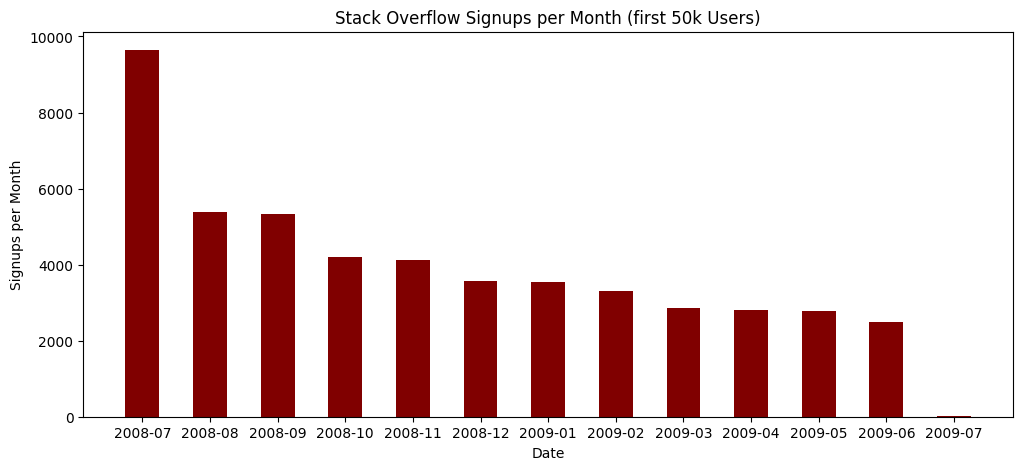

In [18]:
fig = plt.figure(figsize = (12, 5))
 
# creating the bar plot
plt.bar(x, y, color ='maroon',
        width = 0.5)

plt.ylabel("Signups per Month")
plt.xlabel("Date")
plt.title("Stack Overflow Signups per Month (first 50k Users)")
plt.show()

You should get a result similar to this Bar Chart:

![bar_chart](./resources/50k_users_chart.png)

## Example Metric SQL

Let's look at the same metric again, but this time across the entire table, and with more SQL queries.

We'll start off with grouping together Months, Years, and counting the entries for them so that we might see how Users have Adopted the service. We can begin by running SQL directly in our notebooks, then move onto loading that information into something more manageable.

In [ ]:
%load_ext sql

In [ ]:
%sql postgresql+psycopg2://{env['DB_USER']}:{env['DB_PASSWORD']}@{env['DB_HOST']}/{env['DB_NAME']}

In [ ]:
%%sql 

SELECT 
       EXTRACT(YEAR FROM creation_date) AS Year,
       EXTRACT(MONTH FROM creation_date) AS Month,
       COUNT(*) AS Count 
FROM users 
GROUP BY Year, Month
ORDER BY Year, Month

This query takes a long time and spits out a long list, so lets perform the query once and store the information in a DataFrame.

We may also want to combine the Year and Month columns in order to better plot our findings later. Instead of doing that in Pandas, lets do it directly in the SQL query.

In [ ]:
# Load environment variables
load_dotenv()
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

db_params = {
    'dbname': db_name,
    'user': db_user,
    'password': db_password,
    'host': db_host,
    'port': 5432
}

# Create a database connection
conn = psycopg2.connect(**db_params)

# Your SQL query
sql_query = """
SELECT TO_CHAR(creation_date, 'YYYY-MM') AS YearMonth,
       COUNT(*) AS Count 
FROM users 
GROUP BY YearMonth
ORDER BY YearMonth;
"""

# Load the query result into a DataFrame
df = pd.read_sql(sql_query, conn)

# Close the database connection
conn.close()

# Now you have your query results in the 'df' DataFrame
print(df)

## Plotting

Super! We have some results that we can use to interpret, let's plot them in order to make our findings more accessible to Yetunde at Stack Overflow.

In [ ]:
# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="yearmonth", y="count", data=df, palette="viridis")
plt.title("Number of Users per Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()
plt.show()


You may have noticed how busy and inaccessible our `x-axis` has become with all those year-month dates. You may want to set custome x-ticks. You can do all manner of customisations, I simply chose to include the unique years in a list and gaps for the months - but that might not be the best way.

In [ ]:
# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="yearmonth", y="count", data=df, palette="viridis")
plt.title("Number of Users per Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for readability

# Create a list with the desired pattern
year_month_pattern = []

# Get unique years for dropdown options
unique_years = df['yearmonth'].str.split('-').str[0].unique()

for year in unique_years:
    year_month_pattern.append(year)
    year_month_pattern.extend([' '] * (df['yearmonth'].str.startswith(year).sum() - 1))

ax.set_xticklabels(year_month_pattern)

# Show the plot
plt.tight_layout()
plt.show()

You ought to get a chart that looks something like this:

![full_bar_chart](./resources/stack_overflow_adoption_chart.png)

## Interactivity

Let's make that chart a little more interactive. We can use Widgets to create a Year Selector, in order to look at how User Adoption changed throughout the years.

We will need to add the `clear_output` function from the `IPython.display` library if we'd like the one chart to be updated.

In [ ]:
from IPython.display import display, clear_output

def plot_interactive_chart(selected_year):
    filtered_df = df[df['yearmonth'].str.startswith(str(selected_year))]
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="yearmonth", y="count", data=filtered_df, palette="viridis")
    plt.title("Number of Users per Year-Month")
    plt.xlabel("Year-Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Get unique years for dropdown options
unique_years = df['yearmonth'].str.split('-').str[0].unique()

# Create a dropdown for year selection
year_dropdown = widgets.Dropdown(
    options=unique_years,
    description='Select Year:',
    disabled=False,
)

# Display Year Dropdown selector
display(year_dropdown)

# Define the function to update the plot based on the selected year
def update_plot(change):
    clear_output(wait=True)  # Clear the previous chart only
    display(year_dropdown)  # Redisplay the dropdown
    plot_interactive_chart(change.new)

# Connect the dropdown to the update function
year_dropdown.observe(update_plot, names='value')

# Display the dropdown and initial plot
plot_interactive_chart(unique_years[0]) 

In [ ]:
# Display HEART metrics information
print('HEART Metrics for Stack Overflow:\n')
for metric, description in heart_metrics.items():
    print(f'{metric}: {description}')

You can add more interactivity, even have some hover tooltip information with libraries like `plotly` - but for now that will suffice to make our results clear and accessible.

## Launching with Voila

All that's left is to launch with Voila. You should have installed `voila` with `pip` earlier on, but if you haven't you can do that now.

You will want to run the notebook file with the command `voila`, then the filename. You can add the `--debug` flag in order to see debugging information in your terminal.

The command should look something like this:

In [ ]:
voila heart.ipynb --debug

## Process Template

Head over to the [Process Template found here](./process_template.md) to go through these steps with a checklist for each HEART metric, and good luck!